In [1]:
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_I = pd.read_excel("online_retail_II.xlsx") #, nrows=200

In [3]:
df_I.sort_values('InvoiceDate')SS

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525423,538171,20771,CHRYSANTHEMUM JOURNAL,1,2010-12-09 20:01:00,2.55,17530.0,United Kingdom
525424,538171,21882,SKULLS TAPE,5,2010-12-09 20:01:00,0.65,17530.0,United Kingdom
525425,538171,21879,HEARTS GIFT TAPE,5,2010-12-09 20:01:00,0.65,17530.0,United Kingdom
525411,538171,20777,CHRYSANTHEMUM NOTEBOOK,2,2010-12-09 20:01:00,1.65,17530.0,United Kingdom


### Classificação ABC de Estoque

#### Usado para definir quais produtos tem maior representatividade economica, visto que segundo a Teoria " de Pareto?...." 20% dos produtos representam 80% dos lucros, então iremos focar no produto mais relevante dentro desses 20%

In [4]:
df_ABC = df_I.copy()
df_ABC['Date'] = pd.to_datetime(df_ABC['InvoiceDate']).dt.strftime('%Y')
df_ABC = df_ABC.loc[df_ABC['Date'] == '2010']

In [5]:
df_ABC = df_ABC[['Description','Quantity','Price']]
df_ABC = df_ABC.groupby('Description').agg({'Quantity': 'sum', 'Price': 'first'}).reset_index()
# Gerando coluna  de Consumo Anual em R$
df_ABC['R$ CA'] = df_ABC['Quantity'] * df_ABC['Price']
# Ordenando para visualizar os mais relevantes
df_ABC = df_ABC.sort_values('R$ CA', ascending=False).reset_index(drop=True)
df_ABC

,Description,Quantity,Price,R$ CA
0,REGENCY CAKESTAND 3 TIER,13093,12.75,166935.75
1,WHITE HANGING HEART T-LIGHT HOLDER,51330,2.95,151423.50
2,DOTCOM POSTAGE,681,217.09,147838.29
3,MULTI COLOUR SILVER T-LIGHT HOLDER,12039,11.02,132669.78
4,JUMBO BAG RED RETROSPOT,30727,4.21,129360.67
...,...,...,...,...
4525,Adjustment by Peter on 24/05/2010 1,-3,300.13,-900.39
4526,SILVER CHERRY LIGHTS,-96,13.57,-1302.72
4527,SAMPLES,-39,73.80,-2878.20
4528,AMAZON FEE,-5,6706.71,-33533.55


In [6]:
df_ABC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4530 entries, 0 to 4529
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Description  4530 non-null   object 
 1   Quantity     4530 non-null   int64  
 2   Price        4530 non-null   float64
 3   R$ CA        4530 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 141.7+ KB


In [9]:
# Consumo total anual
df_ABC['R$ CA'].sum()

10552138.352999998

In [10]:
#Definindo o % de Consumo em relação ao Total Anual de Consumo
df_ABC['% SKU'] = df_ABC['R$ CA'] / df_ABC['R$ CA'].sum()
# Definindo o % Acumulado de % SKU, para separar as Classes ABC SS
df_ABC['% SKU acumulado'] = (df_ABC['% SKU'].cumsum() * 100).round(2)
df_ABC

,Description,Quantity,Price,R$ CA,% SKU,% SKU acumulado
0,REGENCY CAKESTAND 3 TIER,13093,12.75,166935.75,0.015820,1.58
1,WHITE HANGING HEART T-LIGHT HOLDER,51330,2.95,151423.50,0.014350,3.02
2,DOTCOM POSTAGE,681,217.09,147838.29,0.014010,4.42
3,MULTI COLOUR SILVER T-LIGHT HOLDER,12039,11.02,132669.78,0.012573,5.68
4,JUMBO BAG RED RETROSPOT,30727,4.21,129360.67,0.012259,6.90
...,...,...,...,...,...,...
4525,Adjustment by Peter on 24/05/2010 1,-3,300.13,-900.39,-0.000085,101.88
4526,SILVER CHERRY LIGHTS,-96,13.57,-1302.72,-0.000123,101.87
4527,SAMPLES,-39,73.80,-2878.20,-0.000273,101.84
4528,AMAZON FEE,-5,6706.71,-33533.55,-0.003178,101.52


In [15]:
# Defindo as Classes
import numpy as np
df_ABC['Classe'] = np.where(df_ABC['% SKU acumulado'] <= 80, 'A',
                            np.where(df_ABC['% SKU acumulado'] <= 95, 'B', 'C'))


In [16]:
df_ABC

,Description,Quantity,Price,R$ CA,% SKU,% SKU acumulado,Classe
0,REGENCY CAKESTAND 3 TIER,13093,12.75,166935.75,0.015820,1.58,A
1,WHITE HANGING HEART T-LIGHT HOLDER,51330,2.95,151423.50,0.014350,3.02,A
2,DOTCOM POSTAGE,681,217.09,147838.29,0.014010,4.42,A
3,MULTI COLOUR SILVER T-LIGHT HOLDER,12039,11.02,132669.78,0.012573,5.68,A
4,JUMBO BAG RED RETROSPOT,30727,4.21,129360.67,0.012259,6.90,A
...,...,...,...,...,...,...,...
4525,Adjustment by Peter on 24/05/2010 1,-3,300.13,-900.39,-0.000085,101.88,C
4526,SILVER CHERRY LIGHTS,-96,13.57,-1302.72,-0.000123,101.87,C
4527,SAMPLES,-39,73.80,-2878.20,-0.000273,101.84,C
4528,AMAZON FEE,-5,6706.71,-33533.55,-0.003178,101.52,C


In [12]:
df_ABC['Classe'].count()

4530

In [13]:
df_classe = pd.DataFrame()
df_classe = df_ABC.groupby('Classe').agg({'R$ CA': 'sum', '% SKU': 'sum'}).reset_index()
df_classe =  df_classe.rename(columns={'R$ CA':'Receita Anual','% SKU': '% Receita'})
df_classe

# 80% do valor Total gerado anualmente é gerado pela classe A, que representa apenas 20% do total de produtos vendidos

,Classe,Receita Anual,% Receita
0,A,8441475.410,0.799978
1,B,1583157.060,0.150032
2,C,527505.883,0.049990


In [28]:
# Visualizando o % de cada Classe
df_classe_2 = pd.DataFrame()
df_classe_2['% Classe'] = df_ABC['Classe'].value_counts(normalize=True) * 100
df_classe_2 = df_classe_2.reset_index()
df_classe_2 = df_classe_2.rename(columns={'index':'Classe'})
df_classe_2 = df_classe_2.merge(df_classe).sort_values('Classe')
df_classe_2.to_csv('df_classe_2.csv')
df_classe_2

### Graficos

In [25]:
df_ABC.to_csv('df_ABC_PBI.csv')

In [26]:
df_ABC

,Description,Quantity,Price,R$ CA,% SKU,% SKU acumulado,Classe
0,REGENCY CAKESTAND 3 TIER,13093,12.75,166935.75,0.015820,1.58,A
1,WHITE HANGING HEART T-LIGHT HOLDER,51330,2.95,151423.50,0.014350,3.02,A
2,DOTCOM POSTAGE,681,217.09,147838.29,0.014010,4.42,A
3,MULTI COLOUR SILVER T-LIGHT HOLDER,12039,11.02,132669.78,0.012573,5.68,A
4,JUMBO BAG RED RETROSPOT,30727,4.21,129360.67,0.012259,6.90,A
...,...,...,...,...,...,...,...
4525,Adjustment by Peter on 24/05/2010 1,-3,300.13,-900.39,-0.000085,101.88,C
4526,SILVER CHERRY LIGHTS,-96,13.57,-1302.72,-0.000123,101.87,C
4527,SAMPLES,-39,73.80,-2878.20,-0.000273,101.84,C
4528,AMAZON FEE,-5,6706.71,-33533.55,-0.003178,101.52,C


<AxesSubplot: xlabel='Description', ylabel='% SKU'>

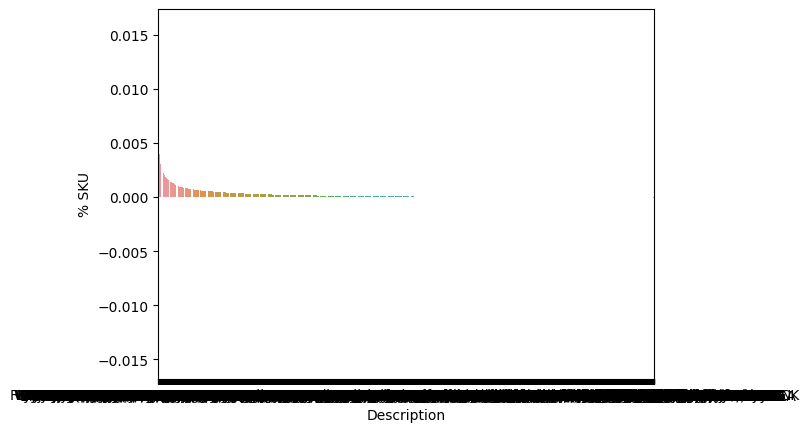

In [27]:
sns.barplot(x='Description', y='% SKU', data=df_ABC)

In [ ]:
# Configurar o estilo do seaborn
sns.set(style="whitegrid")

# Criar o gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x='Description', y='% SKU', data=df_ABC, color='skyblue')
sns.barplot(x='Description', y='% SKU acumulado', data=df_ABC, color='lightpink')

# # Configurar os eixos e rótulos
# plt.xlabel('Description')
# plt.ylabel('Percent')
# plt.title('Percent SKU and SKU Accumulated')
# plt.xticks(rotation=90)
# plt.legend(labels=['% SKU', '% SKU acumulado'])

# Exibir o gráfico
# plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Definir os dados do gráfico
description = df_ABC['Description']
percent_sku = df_ABC['% SKU']
percent_sku_acumulado = df_ABC['% SKU acumulado']

# Configurar o gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))  # Definir o tamanho da figura
index = range(len(description))
bar_width = 0.35

# Plotar as barras para '% SKU'
rects1 = ax.bar(index, percent_sku, bar_width, label='% SKU')

# Plotar as barras para '% SKU acumulado'
rects2 = ax.bar(index, percent_sku_acumulado, bar_width, label='% SKU acumulado')

# Configurar os eixos e rótulos
ax.set_xlabel('Description')
ax.set_ylabel('Percent')
ax.set_title('Percent SKU and SKU Accumulated')
ax.set_xticks(index)
ax.set_xticklabels(description, rotation=90)
ax.legend()

# Exibir o gráfico
plt.tight_layout()
plt.show()


## Gestao de Estoque do primeiro Item da Classe mais representativa

In [18]:
df_varejo = df_I.loc[df_I['Description'] == 'REGENCY CAKESTAND 3 TIER']

# df_varejo['InvoiceDate'] = pd.to_datetime(df_varejo['InvoiceDate']).dt.date.format('%Y-%m-%d')
df_varejo['Date'] = pd.to_datetime(df_varejo['InvoiceDate']).dt.strftime('%Y-%m')
df_varejo = df_varejo[['Date','Quantity']]
df_varejo = df_varejo.groupby('Date').sum()
# df_varejo.set_index('Date', inplace=True)
df_varejo

C:\Users\janaina\AppData\Local\Temp\ipykernel_6032\1002843327.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_varejo['Date'] = pd.to_datetime(df_varejo['InvoiceDate']).dt.strftime('%Y-%m')


,Quantity
Date,
2010-03,749
2010-04,1153
2010-05,490
2010-06,1357
2010-07,1413
2010-08,1025
2010-09,1962
2010-10,1872
2010-11,2030


In [19]:
df_varejo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 2010-03 to 2010-12
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Quantity  10 non-null     int64
dtypes: int64(1)
memory usage: 160.0+ bytes


In [20]:
# Media total/diaria 15.16; desvio padrao 16.54
df_varejo.describe()

,Quantity
count,10.000000
mean,1309.300000
std,520.360996
min,490.000000
25%,1029.250000
50%,1255.000000
75%,1757.250000
max,2030.000000


Text(0.5, 1.0, 'Demanda "REGENCY CAKESTAND 3 TIER"')

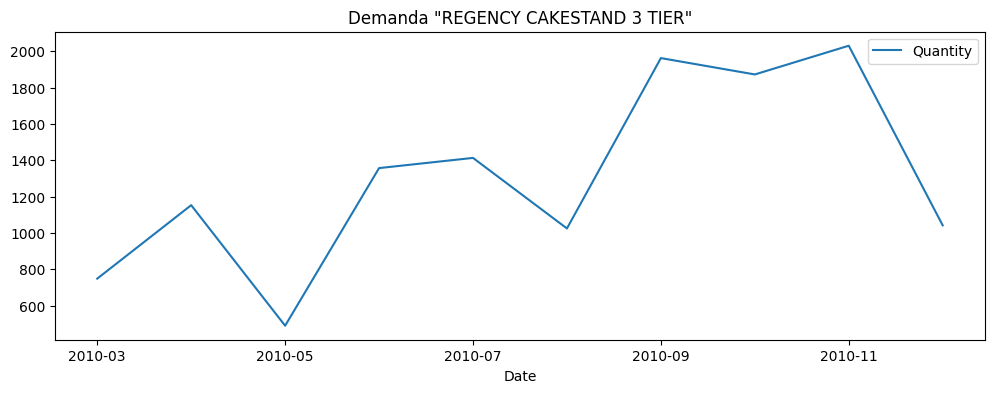

In [21]:
df_varejo.plot(figsize=(12, 4))
plt.title('Demanda "REGENCY CAKESTAND 3 TIER"')

Text(0.5, 1.0, 'Distribuição "REGENCY CAKESTAND 3 TIER"')

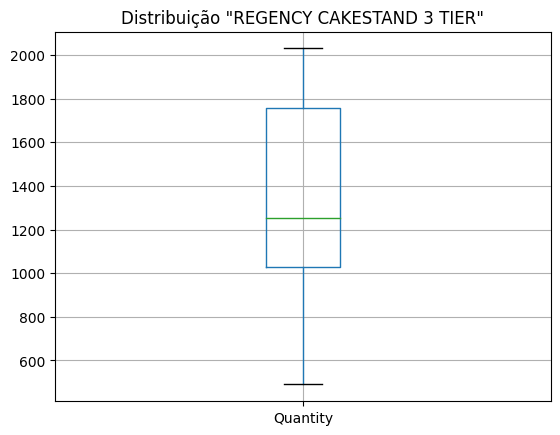

In [22]:
df_varejo.boxplot()
plt.title('Distribuição "REGENCY CAKESTAND 3 TIER"')

In [ ]:
# Estoque Minimo
# Calculando Estoque Mnimo (quantidade ideal para atender as demandas dos clientes)
# calculo doconsumo medio mensal: (total consumo anual/12... se for apenas 6 meses, soma os 6 meses/6)
# Nivel de atendimento: quantidade total em %percentual que me comprometo atender das demandas
# estoque minimo = consumo medio mensal X Nivel de atendimento
CMM = df_varejo['Quantity'].mean()
E_Mn = CMM * 0.80
E_Mn.round(2)

In [ ]:
# Estoque Maximo
# Calculando Estoque Maximo ( trata-se do estoque limite suportado)
# estoque maximo = estoque minimo X Fator (fator = 1, 2, 3....)
E_Mx = E_Mn * 2
E_Mx.round(2)

In [ ]:
# Tempo de Reposição (Lead Time)
# por default o TR é mensal, devido ao consumo medio mensal
# TR por dia:
# TR = CMM/30
# TR = TR * total_dias_lead_time

In [ ]:
# Ponto de Pedido (reposição)
# CMM: Consumo Médio(quantidade consumida por mes); TR: Tempo de reposição em meses; ES: estoque de segurança
# PP = CMM X TR X ES
PP = CMM * 1 #+ CMM
PP.round(2)

In [ ]:
# estoque de Segurança
# Se CMM em dias TR precisa estar em dias, se CMM mensal TR precisa estar mensal
# ES = CMM * TR

In [ ]:
df_graf = df_varejo.copy()
df_graf= df_graf.reset_index()
df_graf

In [ ]:
periodos = df_graf['Date'].values
demanda = df_graf['Quantity'].values
# Criar gráfico de dente de serra
plt.plot(periodos, demanda, '-o')  # '-o' para exibir pontos e linhas conectando-os
plt.xlabel('Período')
plt.ylabel('Estoque')
plt.title('Demanda Mensal')
plt.grid(True)

# Exibir o gráfico
plt.show()

In [ ]:
ponto_pedido = PP  # Ponto de pedido
estoque_maximo = E_Mx  # Estoque máximo permitido
estoque_minimo = E_Mn  # Estoque mínimo permitido
# ponto_reposicao = 9  # Ponto de reposição

# Criar gráfico de dente de serra
plt.plot(periodos, demanda, '-o')  # '-o' para exibir pontos e linhas conectando-os

# Destacar pontos de pedido, estoque máximo, estoque mínimo e ponto de reposição
plt.scatter(periodos, demanda, c='black')  # Pontos de estoque em preto
plt.axhline(y=ponto_pedido, color='red', linestyle='--', label='Ponto de Pedido')
plt.axhline(y=estoque_maximo, color='green', linestyle='--', label='Estoque Máximo')
plt.axhline(y=estoque_minimo, color='orange', linestyle='--', label='Estoque Mínimo')
# plt.axvline(x=ponto_reposicao, color='blue', linestyle='--', label='Ponto de Reposição')

# Configurar legendas
plt.legend()

# Configurar rótulos dos eixos
plt.xlabel('Período')
plt.ylabel('Estoque')

# Configurar título do gráfico
plt.title('Gestão de Estoque')

# Exibir o gráfico
plt.show()
